Problem Formulation:Given historical stock price data, including opening prices, closing prices, high and low prices, trading volumes, and potentially additional technical indicators, the task is to build an LSTM-based predictive model capable of forecasting the future price of a specific stock or stock market index. The objective of this project is to develop a predictive model using Long Short-Term Memory (LSTM) neural networks to forecast future stock prices for a given company or stock market index. The goal is to provide accurate and reliable predictions that can assist investors and traders in making informed decisions regarding buying, selling, or holding stock positions.

Packages and Data

In [1]:
# Import Libraries
import numpy as np               # For numerical operations
import pandas as pd              # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns            # For data visualization
import tensorflow as tf          # For deep learning models
import requests                  # for url requests


# Hide Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Upload Data
# Define your Alpha Vantage API key
api_key = 'YOUR_API_KEY'

# Specify the stock symbol and the API endpoint
symbol = 'AAPL'  # Apple stock data
api_endpoint = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s" %(symbol,api_key)

# Fetch the stock price data from Alpha Vantage
response = requests.get(api_endpoint)
data = response.json()['Time Series (Daily)']

# Convert the data to a DataFrame and clean it
stock_df = pd.DataFrame.from_dict(data, orient='index')
stock_df.index = pd.to_datetime(stock_df.index)
stock_df = stock_df.astype(float)
stock_df = stock_df.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume',
})


In [3]:
stock_df.head()

,Open,High,Low,Close,Volume
2023-09-22,174.67,177.079,174.05,174.79,56725385.0
2023-09-21,174.55,176.300,173.86,173.93,63149116.0
2023-09-20,179.26,179.695,175.40,175.49,58436181.0
2023-09-19,177.52,179.630,177.13,179.07,51826941.0
2023-09-18,176.48,179.380,176.17,177.97,67257573.0


In [4]:
stock_df.shape

(6012, 5)

Data cleaning

In [5]:

# Reverse the DataFrame to have the latest data at the end
stock_df = stock_df.iloc[::-1]
stock_df.head()

,Open,High,Low,Close,Volume
1999-11-01,80.00,80.69,77.37,77.62,2487300.0
1999-11-02,78.00,81.69,77.31,80.25,3564600.0
1999-11-03,81.62,83.25,81.00,81.50,2932700.0
1999-11-04,82.06,85.37,80.62,83.62,3384700.0
1999-11-05,84.62,88.37,84.00,88.31,3721500.0


In [6]:
# Check for missing values
missing_values = stock_df.isnull().sum()
print("Missing Values:")
print(missing_values)


Missing Values:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [7]:
# Summary statistics
summary_stats = stock_df.describe()
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
              Open         High          Low        Close        Volume
count  6012.000000  6012.000000  6012.000000  6012.000000  6.012000e+03
mean    173.267387   175.200645   171.225365   173.269433  3.199913e+07
std     150.265693   151.505743   148.822047   150.199957  3.015577e+07
min      12.990000    13.190000    12.720000    13.120000  7.025000e+05
25%      72.250000    72.980000    71.187500    72.045000  1.142935e+07
50%     132.885000   134.650000   131.082500   132.700000  2.344136e+07
75%     200.332500   202.087500   198.380000   200.389000  4.151760e+07
max     702.410000   705.070000   699.570000   702.100000  3.326072e+08


Exploratory Data Analysis

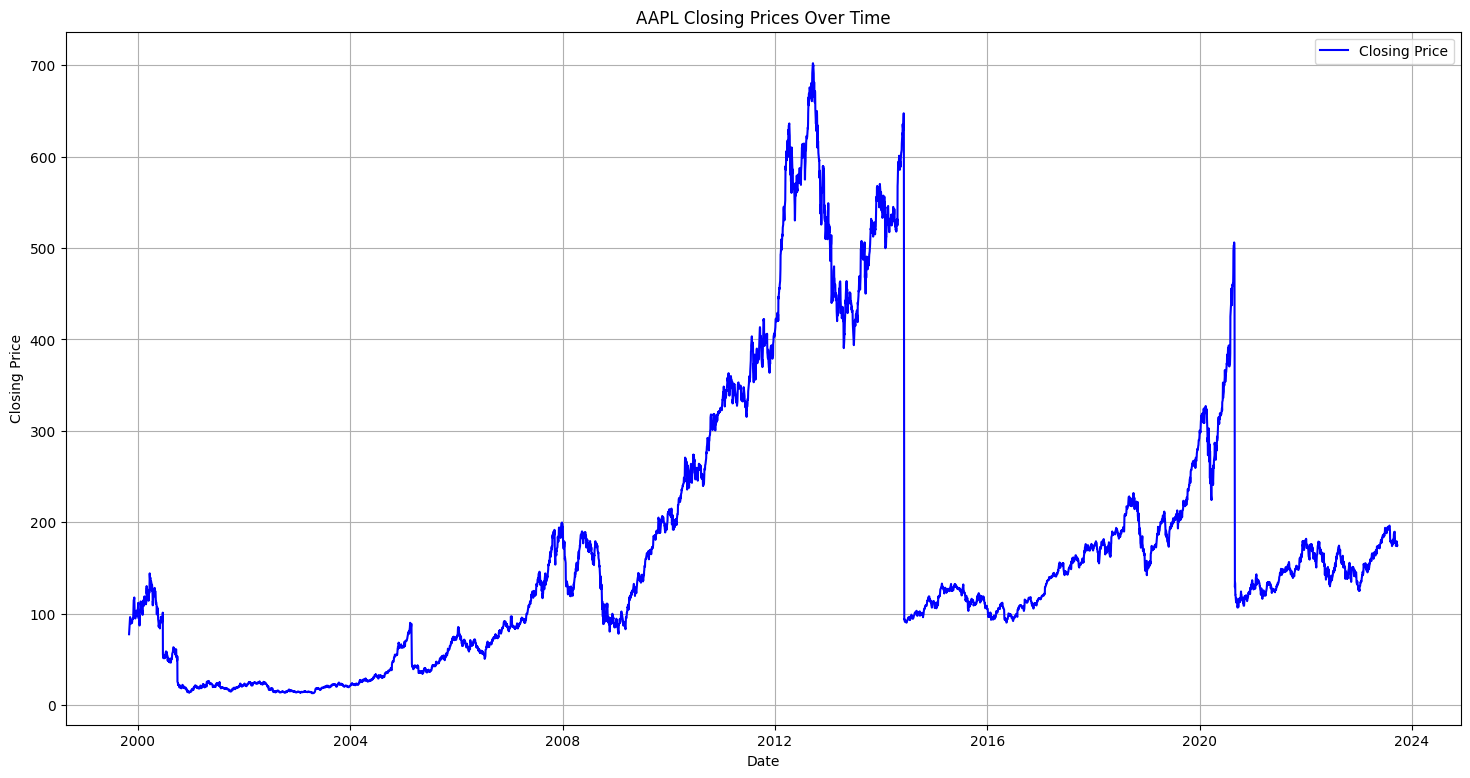

In [8]:
# Plot Closing Price over time
plt.figure(figsize=(18, 9))
plt.plot(stock_df['Close'], label='Closing Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('AAPL Closing Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()

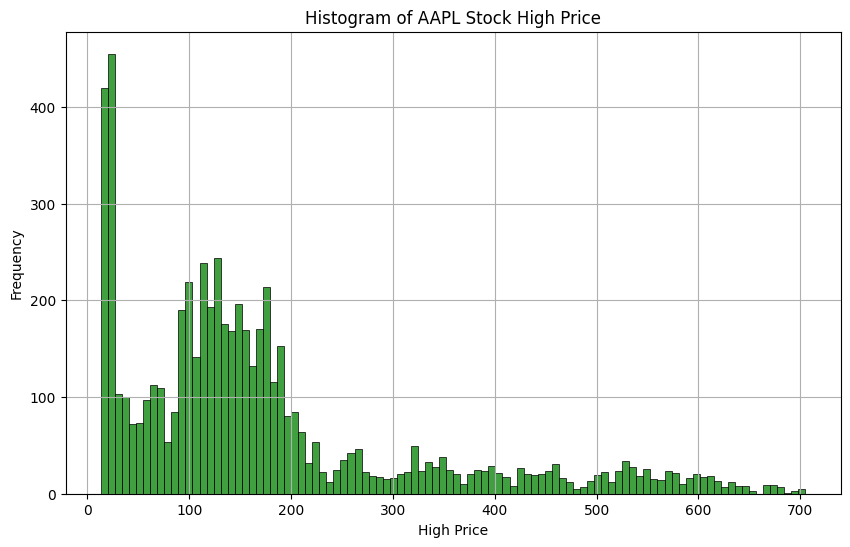

In [9]:
# Histogram of High Price
plt.figure(figsize=(10, 6))
sns.histplot(stock_df['High'].dropna(), bins=100, color='green')
plt.xlabel('High Price')
plt.ylabel('Frequency')
plt.title('Histogram of AAPL Stock High Price')
plt.grid(True)
plt.show()

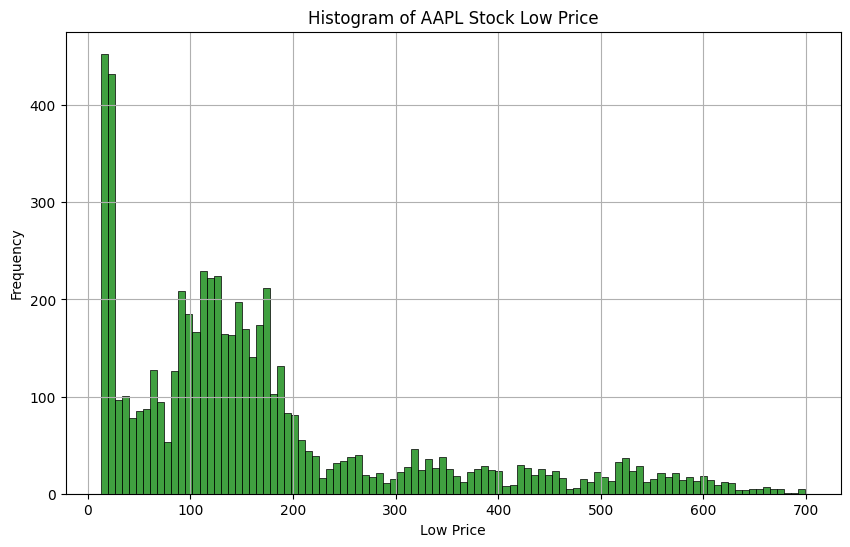

In [10]:
# Histogram of Low Price
plt.figure(figsize=(10, 6))
sns.histplot(stock_df['Low'].dropna(), bins=100, color='green')
plt.xlabel('Low Price')
plt.ylabel('Frequency')
plt.title('Histogram of AAPL Stock Low Price')
plt.grid(True)
plt.show()

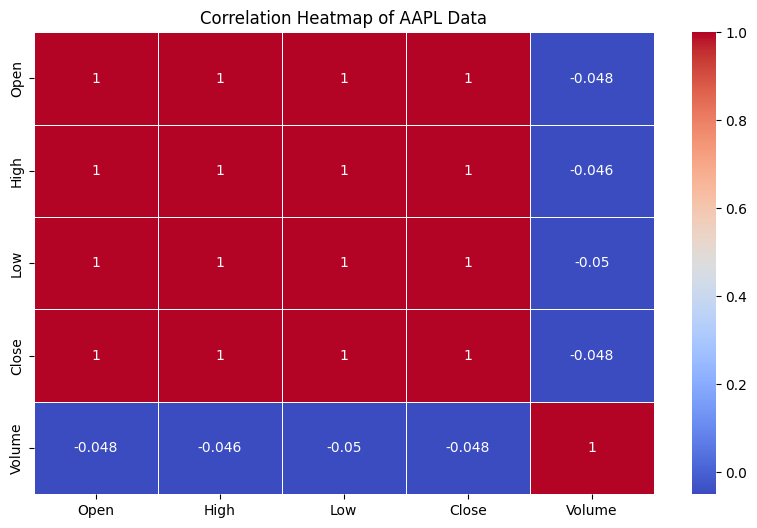

In [11]:
# Heatmap of correlation matrix
correlation_matrix = stock_df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of AAPL Data')
plt.show()

Feature Selection

In [12]:
# Specify the feature columns (X) and the target column (y)
# For this example, let's use the 'Close' price as the target variable
X = stock_df[['Open', 'High', 'Low', 'Volume']]
y = stock_df['Close']

In [13]:
# Split the data into training and test sets (e.g., 80% training, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Optionally, you can reset the index of the resulting DataFrames
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [15]:
# Print the dimensions of the training and test sets
print(f"Training set dimensions: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Test set dimensions: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")

Training set dimensions: X_train shape = (4809, 4), y_train shape = (4809,)
Test set dimensions: X_test shape = (1203, 4), y_test shape = (1203,)


Model Development

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Define the model
model = Sequential()

# Add an LSTM layer with 50 units
model.add(LSTM(50, return_sequences= 'True', input_shape=(X_train.shape[1], 1)))
model.add(LSTM(25, return_sequences=False))

# Add a Dense (fully connected) layer with one unit for regression
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of the model architecture
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 25)                650       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18676 (72.95 KB)
Trainable params: 18676 (72.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
151/151 [==============================] - 7s 9ms/step - loss: 46340.0820
Epoch 2/50
151/151 [==============================] - 1s 7ms/step -

Prediction

38/38 [==============================] - 2s 3ms/step


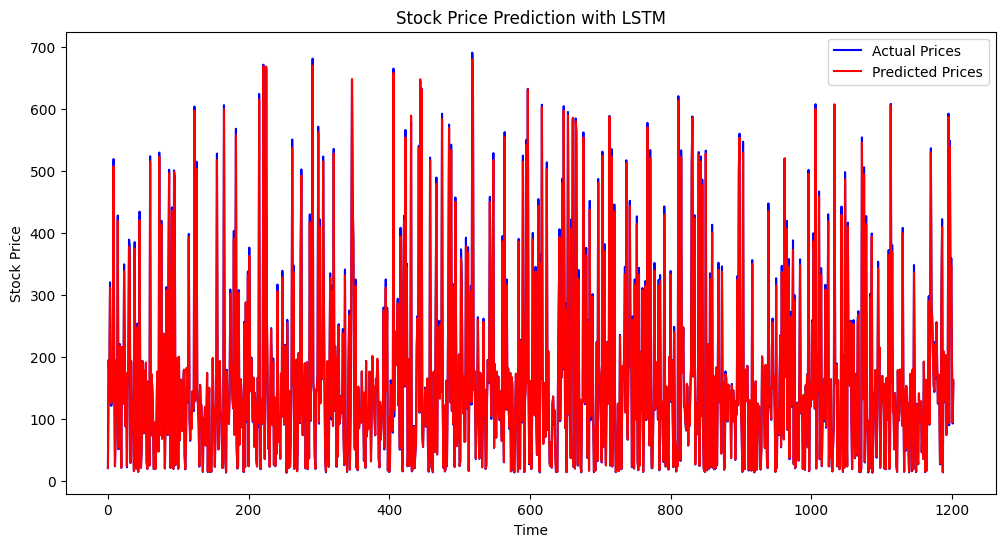

In [17]:
# Make predictions on the test data
predictions = model.predict(X_test)

# Plot the actual vs. predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.show()

In [18]:
# Make predictions on new data
# features = [Open, High, Low, Adj Close, Volume]
features = np.array([[177.089996, 180.419998, 177.070007, 74919600]])
forecast = model.predict(features)
print('Forecast:')
print(forecast)

1/1 [==============================] - 1s 1s/step
Forecast:
[[178.46956]]


Evaluation

In [19]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 4.144927669316936


Deployment